In [1]:
import gzip
import pandas
import pickle
import seaborn
import tqdm

from lib.models.aft20barzur import ptmdp
from lib.models.generic_v0.model import map_params

In [2]:
mdps = pandas.read_pickle("5-generated-mdps/fixed.pkl.gz")
mdps

,scenario,model,protocol,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,dag_size_limit,size,time_spent,rss,mdp
0,baseline,generic_1,bitcoin,False,False,True,True,False,6,21327,14.337590,0.344711,67431272
1,baseline,generic_1,ethereum_3,False,False,True,True,False,6,32961,23.533842,0.444691,237ddef6
2,baseline,generic_1,byzantium_3,False,False,True,True,False,6,33016,25.439894,0.445202,4119c592
3,baseline,generic_1,ghostdag_3,False,False,True,True,False,6,46966,42.391177,0.543610,68f64dc1
4,baseline,generic_1,parallel_3,False,False,True,True,False,6,9122,5.645696,0.280853,210e398f
5,w/ force consider,generic_1,bitcoin,True,False,True,True,False,6,549,0.251836,0.268513,19510cc6
6,w/ force consider,generic_1,ethereum_3,True,False,True,True,False,6,1179,0.750322,0.271481,644da330
7,w/ force consider,generic_1,byzantium_3,True,False,True,True,False,6,1109,0.786487,0.273792,7fa5ad1d
8,w/ force consider,generic_1,ghostdag_3,True,False,True,True,False,6,1527,1.506184,0.273724,3381ee42
9,w/ force consider,generic_1,parallel_3,True,False,True,True,False,6,2175,1.154101,0.315636,1b96749a


In [3]:
networks = []
# for alpha in range(5, 51, 5):
for alpha in range(35, 41, 5):
    for gamma in [0.33, 0.66]:
        # for gamma in [0, 0.5, 1]:
        networks.append(dict(alpha=alpha / 100, gamma=gamma))
# pandas.DataFrame(networks)

In [4]:
horizon = 100
stop_delta = (
    0.001  # value iteration stops when no value estimate changes more than this value
)

with tqdm.tqdm(total=len(networks) * len(mdps)) as pbar:
    rows = []
    for network in networks:
        for i, row in mdps.iterrows():
            with gzip.open(f"5-generated-mdps/mdp-{row.mdp}.pkl.gz", "rb") as f:
                emdp = pickle.load(f)
            emdp = map_params(emdp, **network)
            emdp = ptmdp(emdp, horizon=horizon)
            vi = emdp.value_iteration(discount=1, stop_delta=stop_delta)
            policy = vi.pop("vi_policy")
            state_fut_reward = vi.pop("vi_value")
            state_fut_progress = vi.pop("vi_progress")

            episode_reward = 0
            episode_progress = 0
            for state, prb in emdp.start.items():
                episode_reward += prb * state_fut_reward[state]
                episode_progress += prb * state_fut_progress[state]

            res = dict(
                episode_reward=episode_reward,
                episode_progress=episode_progress,
                episode_reward_per_progress=episode_reward / episode_progress,
            )

            rows.append(row.to_dict() | network | vi | res)

            pbar.update(1)

df = pandas.DataFrame(rows)
df.to_pickle("5-value-iterations.pkl.gz")
df

100%|███████████████████████████████████████████████████████| 80/80 [1:11:51<00:00, 53.89s/it]


,scenario,model,protocol,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,dag_size_limit,size,...,gamma,vi_discount,vi_delta,vi_stop_delta,vi_iter,vi_max_iter,vi_time,episode_reward,episode_progress,episode_reward_per_progress
0,baseline,generic_1,bitcoin,False,False,True,True,False,6,21327,...,0.33,1,0.000999,0.001,1416,0,124.210397,36.645256,98.251549,0.372974
1,baseline,generic_1,ethereum_3,False,False,True,True,False,6,32961,...,0.33,1,0.000999,0.001,1740,0,213.215120,50.585667,98.353593,0.514325
2,baseline,generic_1,byzantium_3,False,False,True,True,False,6,33016,...,0.33,1,0.001000,0.001,1274,0,167.074785,35.591285,98.175497,0.362527
3,baseline,generic_1,ghostdag_3,False,False,True,True,False,6,46966,...,0.33,1,0.000998,0.001,1250,0,207.390314,36.424970,98.112676,0.371257
4,baseline,generic_1,parallel_3,False,False,True,True,False,6,9122,...,0.33,1,0.000997,0.001,1391,0,45.796979,40.110577,96.870341,0.414065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,w/ both,generic_1,bitcoin,True,True,True,True,False,6,300,...,0.66,1,0.000997,0.001,1619,0,1.683584,50.993481,98.639087,0.516970
76,w/ both,generic_1,ethereum_3,True,True,True,True,False,6,596,...,0.66,1,0.000995,0.001,1458,0,2.754315,52.981254,98.445556,0.538178
77,w/ both,generic_1,byzantium_3,True,True,True,True,False,6,572,...,0.66,1,0.000998,0.001,1395,0,2.682542,46.480770,98.483476,0.471965
78,w/ both,generic_1,ghostdag_3,True,True,True,True,False,6,604,...,0.66,1,0.000991,0.001,1086,0,2.322080,40.086100,98.145192,0.408437


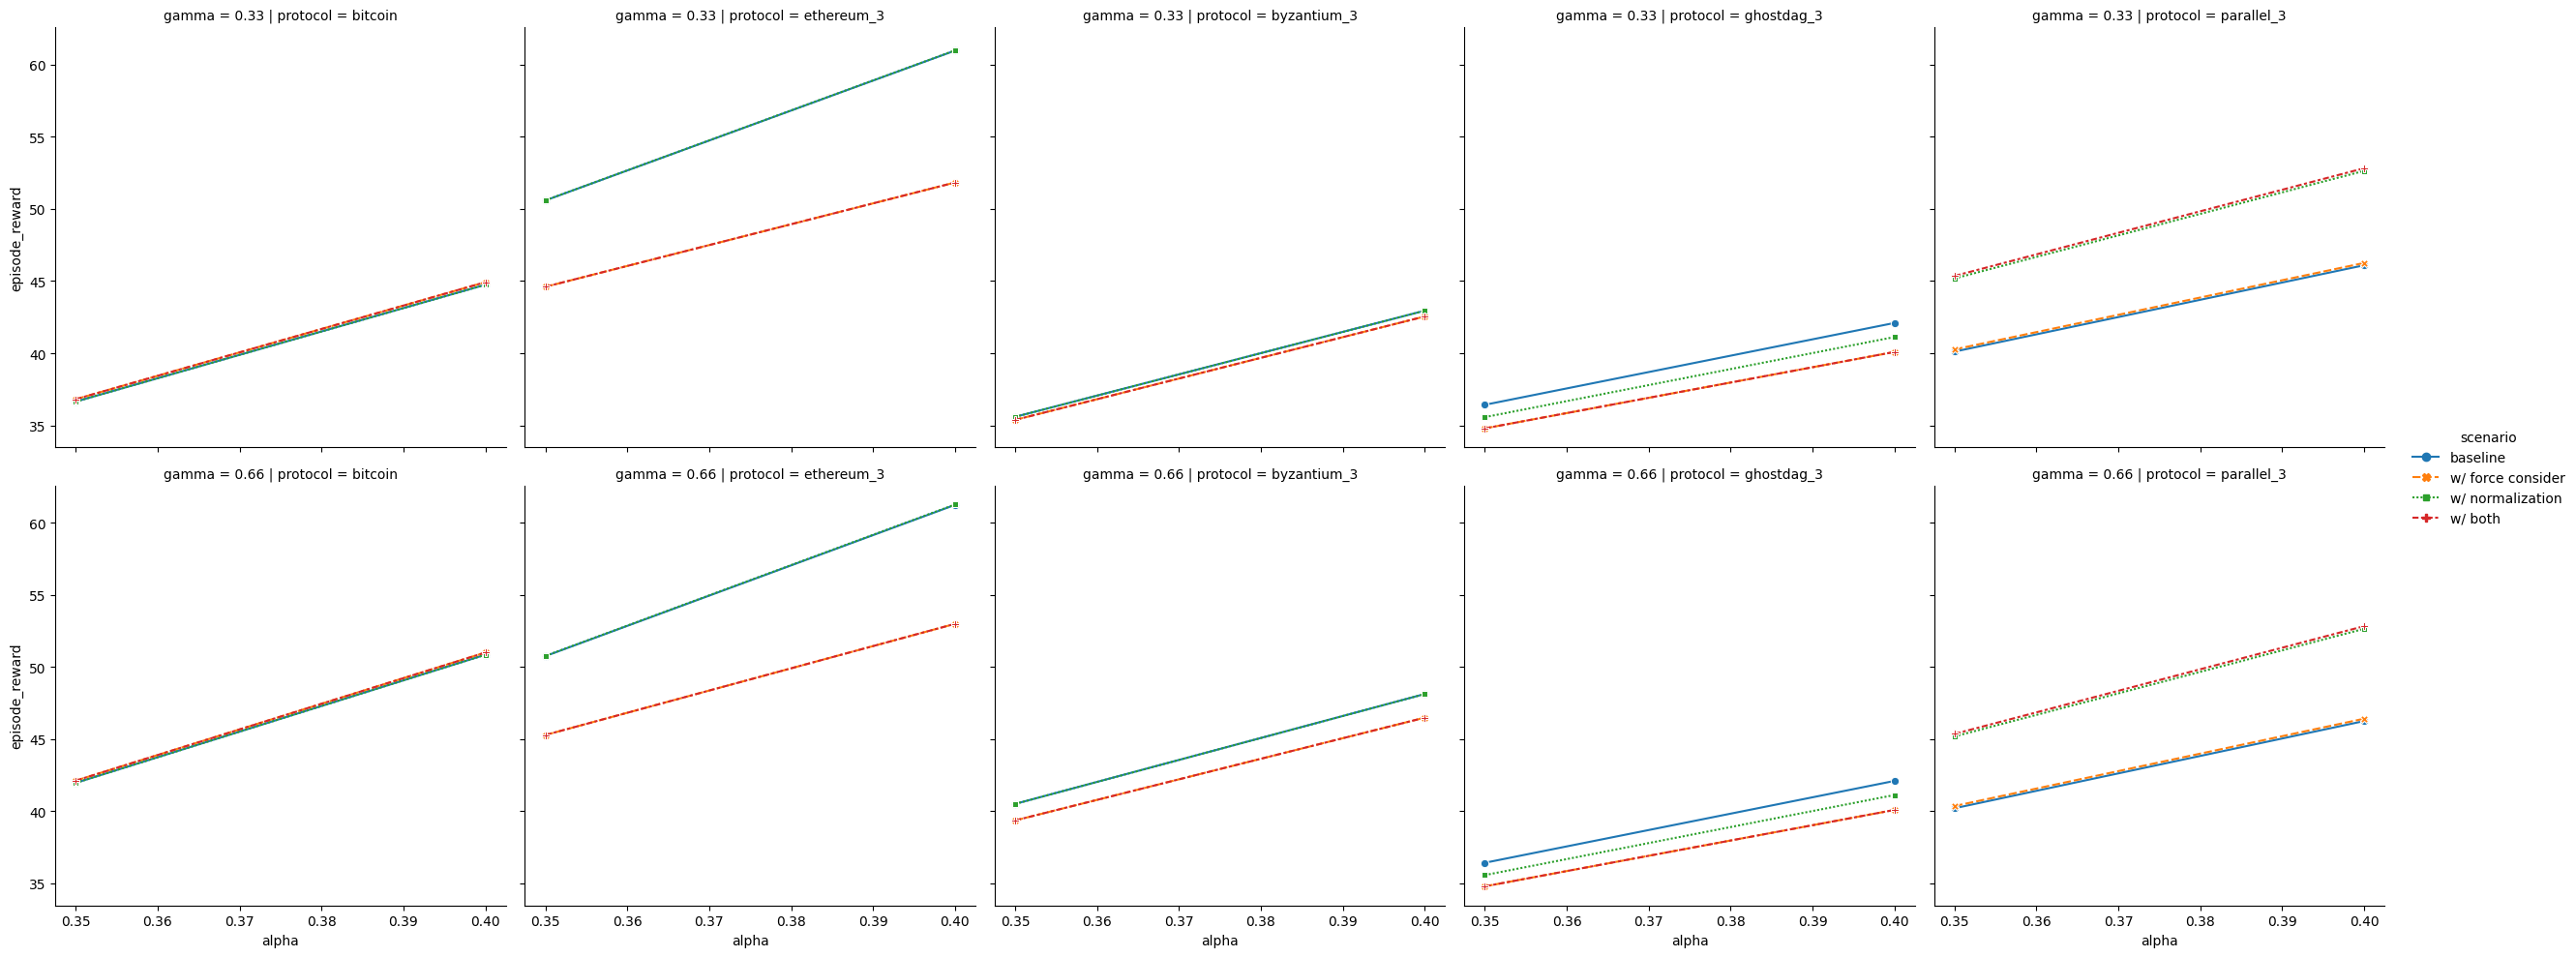

In [5]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_reward",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)

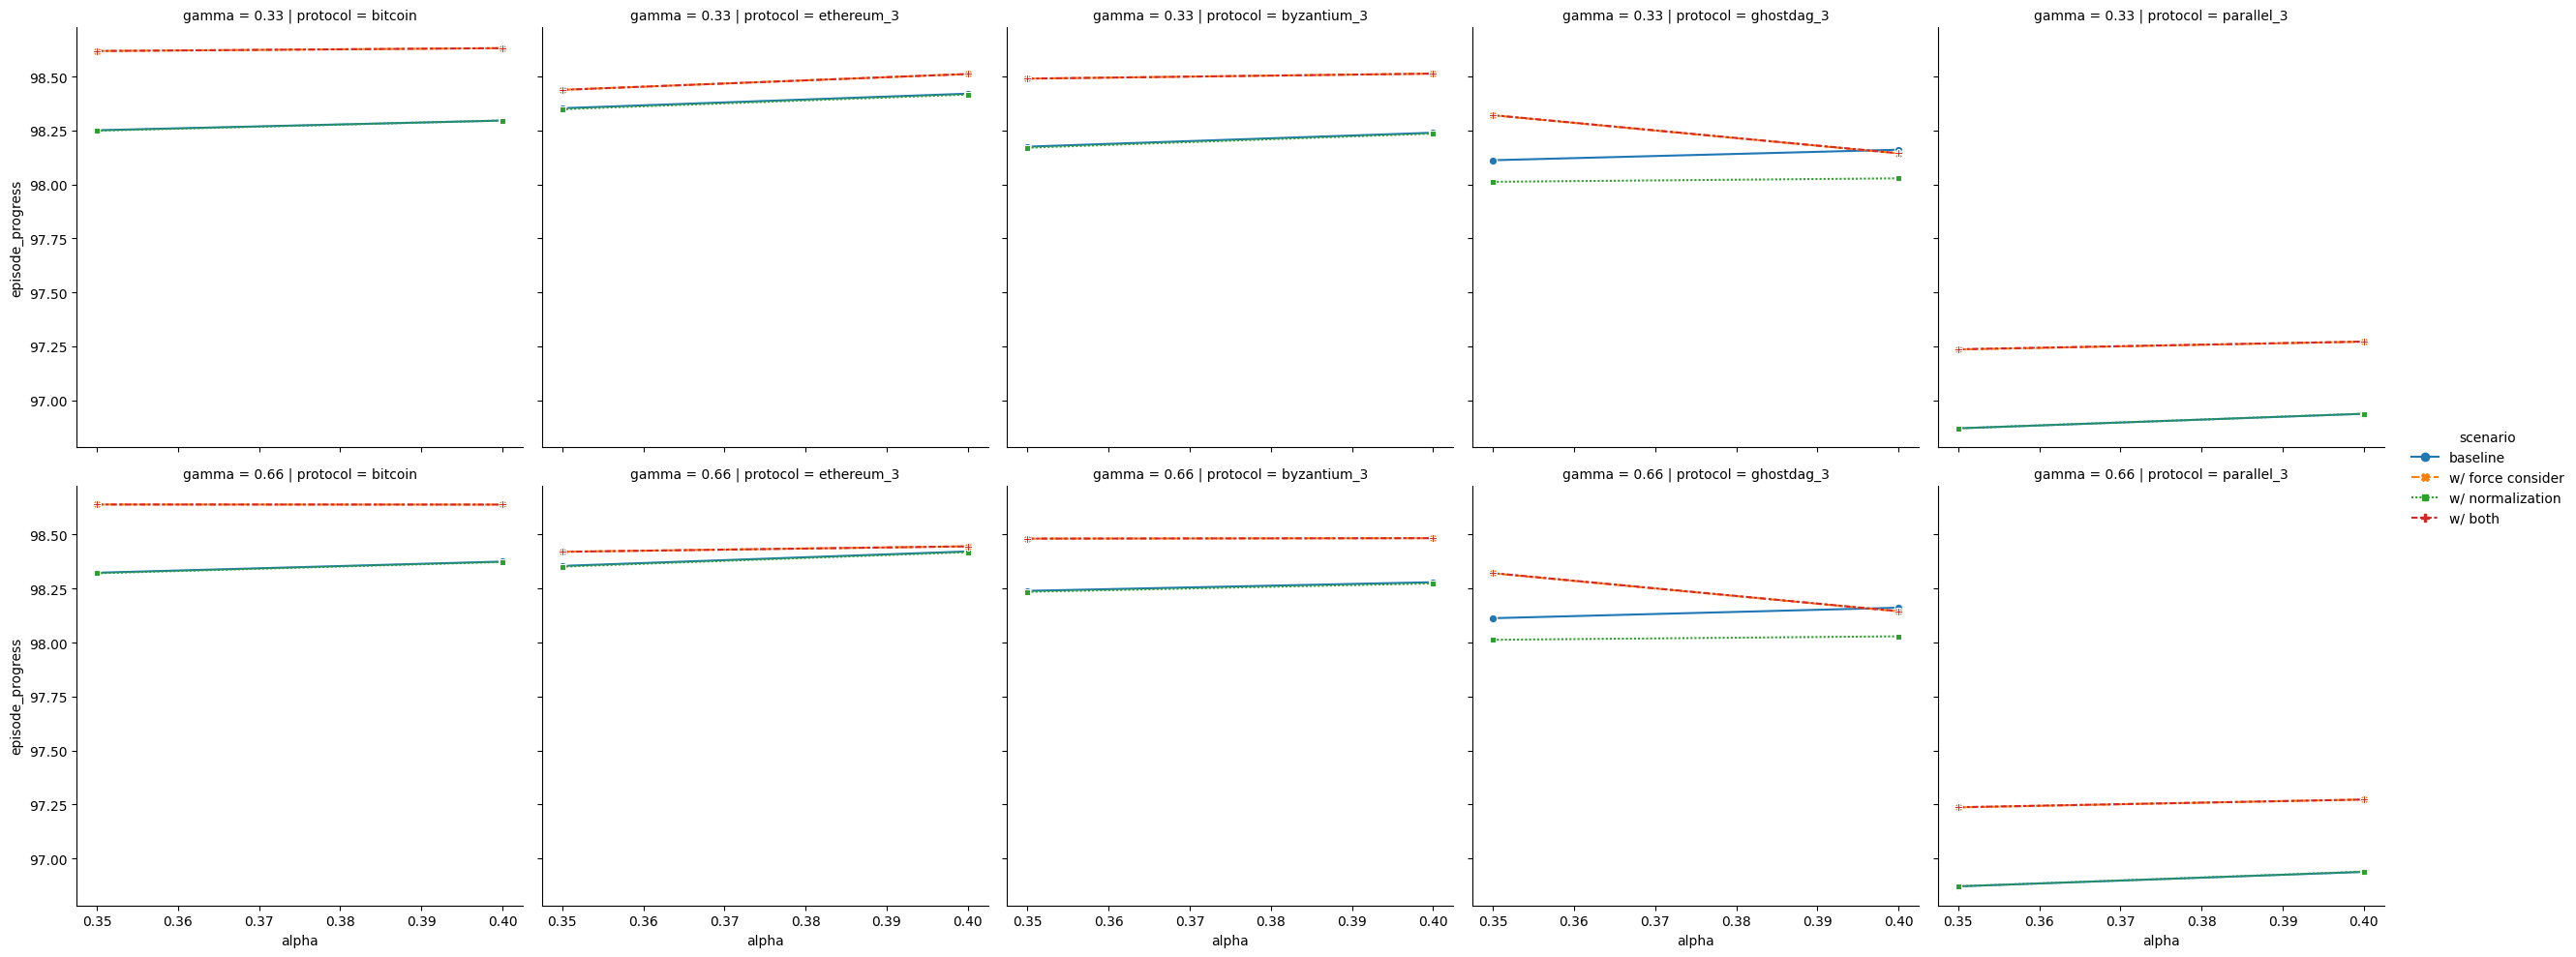

In [6]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_progress",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)

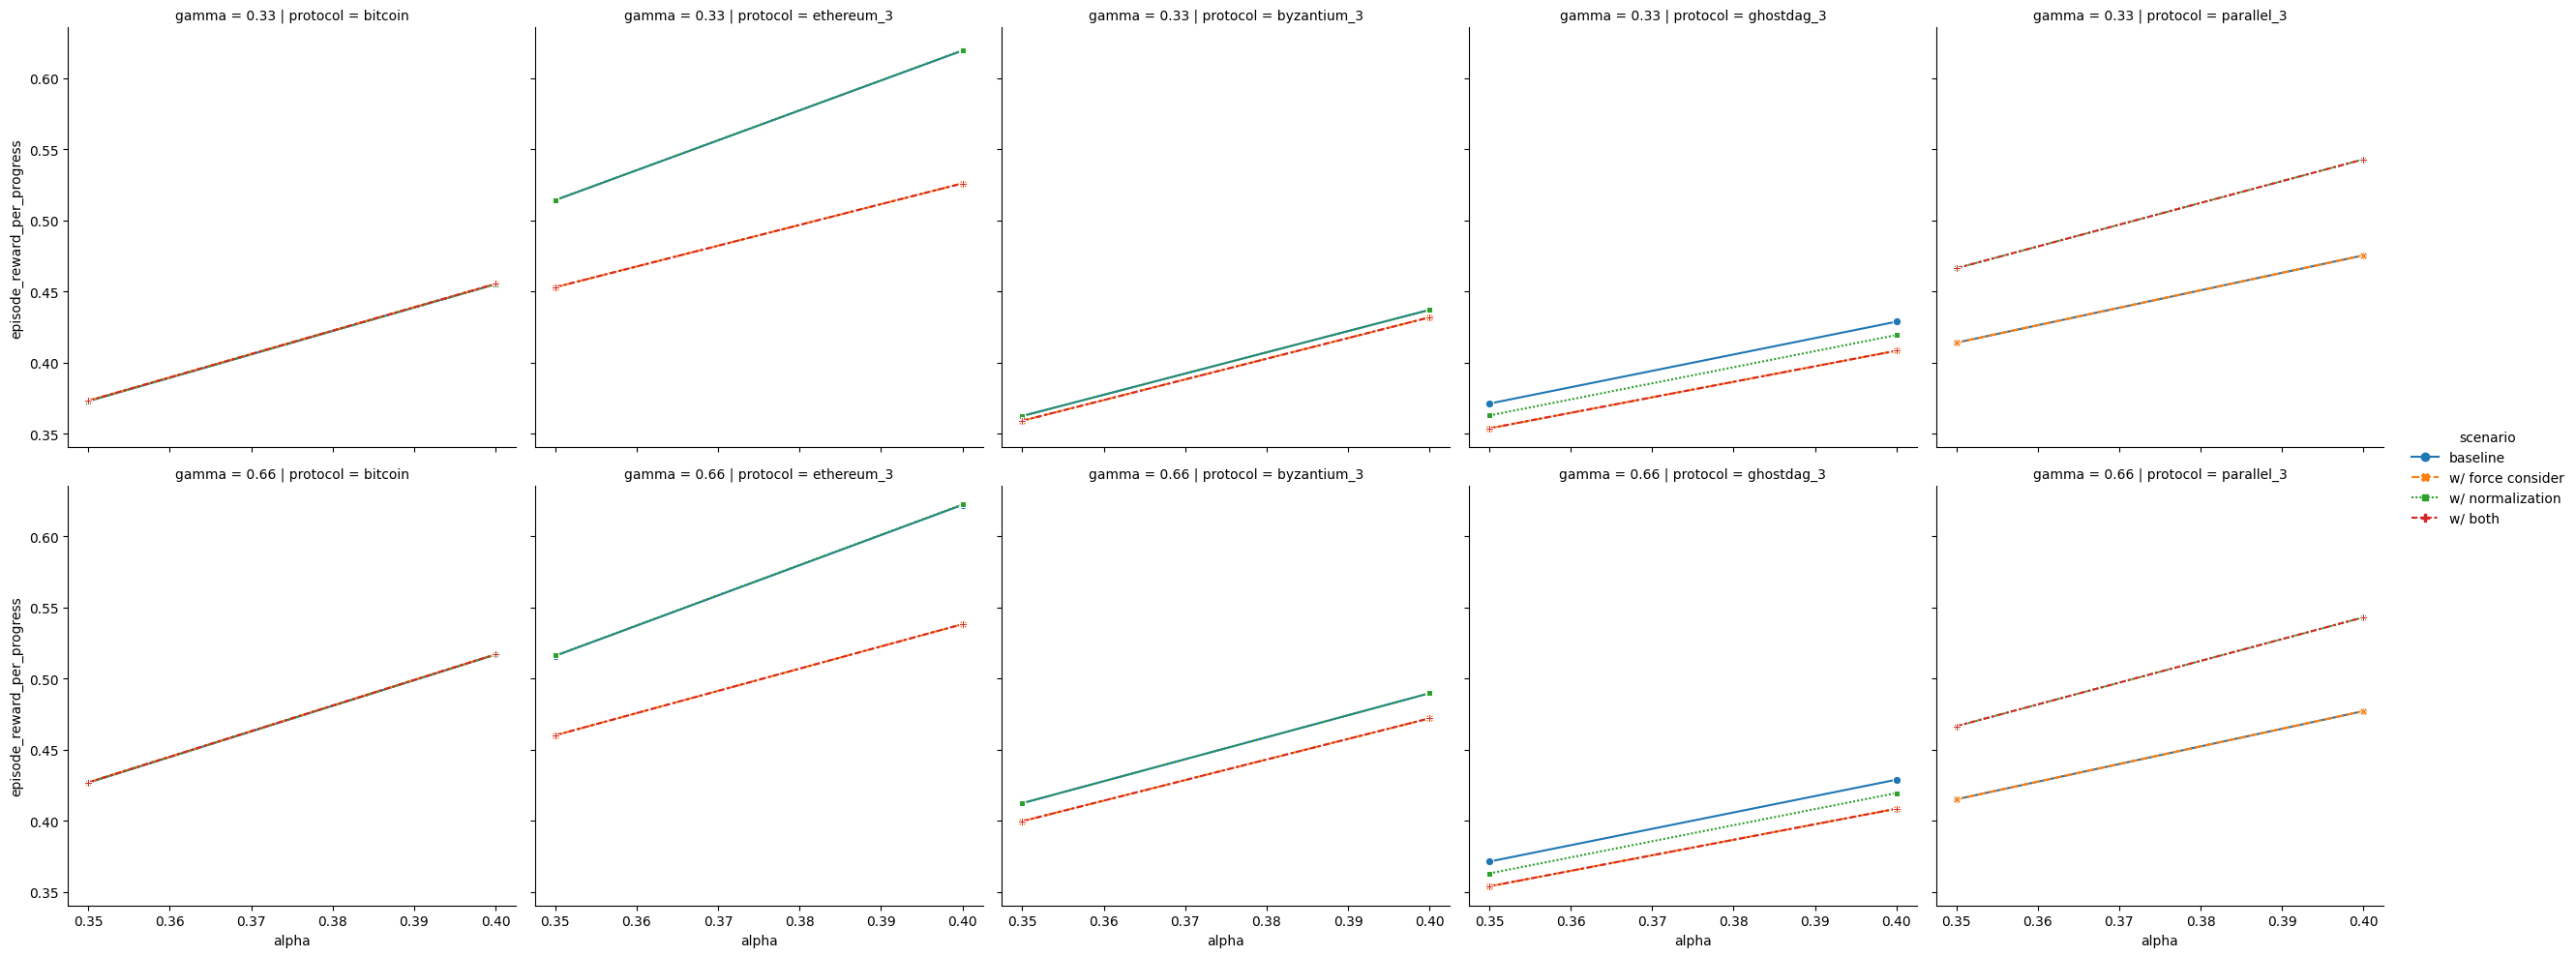

In [7]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_reward_per_progress",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)

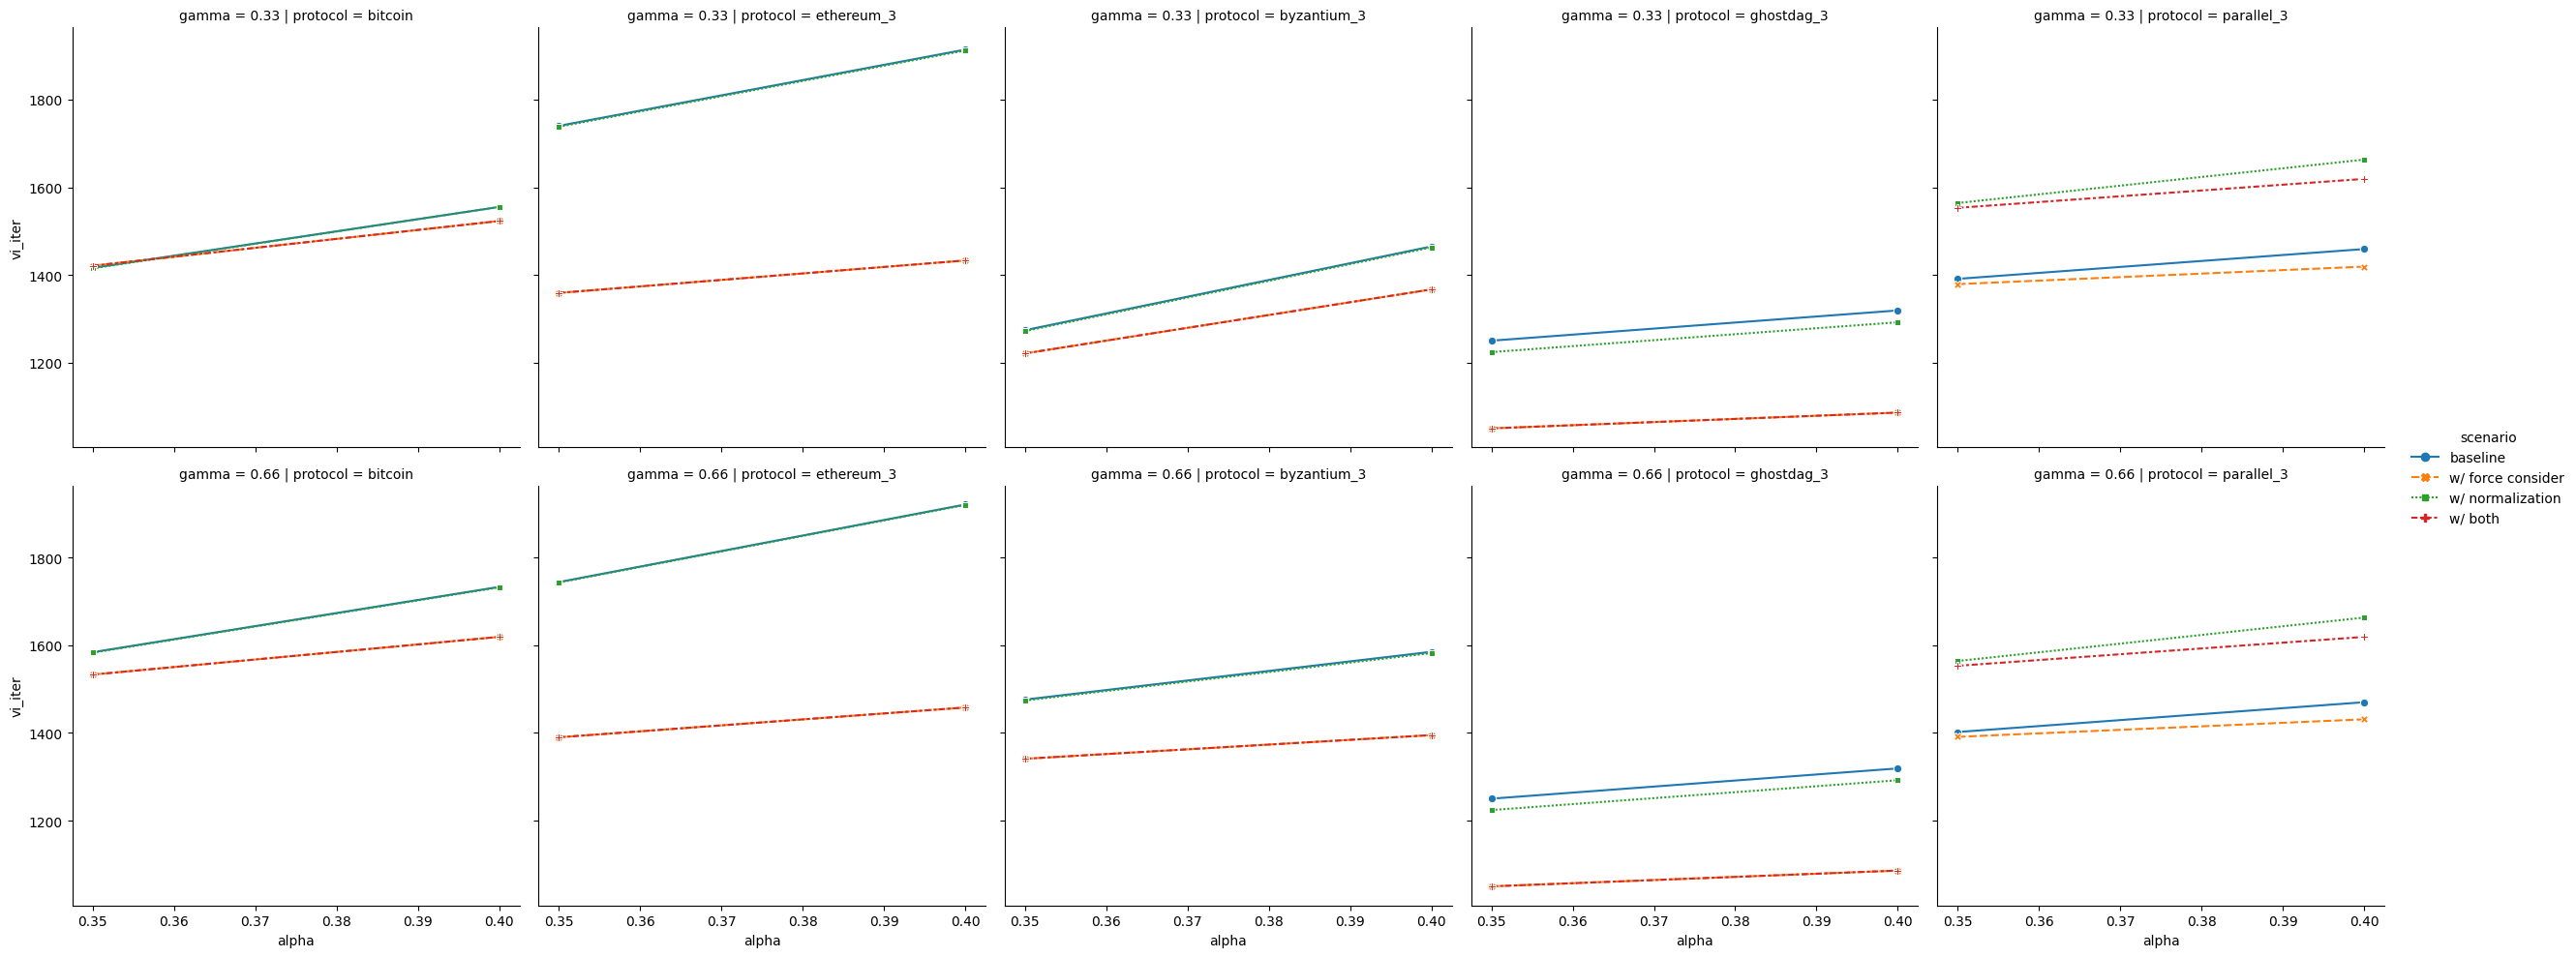

In [8]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="vi_iter",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)